import numpy as np
import xarray as xr
import climpred
import proplot as plot`
import glob
from tqdm import tqdm
import dask.array as da
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FixedLocator
import math
import warnings
warnings.filterwarnings("ignore")

from dask.distributed import Client
import dask.config
dask.config.set({"array.slicing.split_large_chunks": False})

In [ ]:
print( climpred.__version__)

In [ ]:
# %pip install git+https://github.com/pangeo-data/climpred.git
    

In [ ]:
client = Client("tcp://10.12.1.3:39258")

In [ ]:
verifdata = "CPC" #can be ERA5 or CPC
#domain = "global"
domain = "North America"
metric = "rpss" #can be rps, crps, crpss, rmse, acc
if metric == "acc" or metric=="rmse":
    comp="e2o"
    dim="init"
else:
    comp="m2o"
    dim=["init","member"]

In [73]:
hinda2 = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/CESM2.S2S.tas_2m.anoms.wklead.zarr/", consolidated=True)
hinda1 = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/CESM1.S2S.tas_2m.anoms.wklead.zarr/", consolidated=True)
hindaw = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/WACCM.S2S.tas_2m.anoms.wklead.zarr/", consolidated=True)
verif = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/"+verifdata+".tas.zarr/", consolidated=True)
#verif = xr.open_dataset("/glade/work/sglanvil/CCR/S2S/data/tas_2m_anom_CPC_sg_s2s_data.nc")
#verif = xr.open_dataset("/glade/scratch/jaye/CPC/tas_2m_anom_CPC_sg_s2s_data.nc")
land = xr.open_dataset("/glade/work/jaye/landsea.nc")

In [74]:
verif

<xarray.Dataset>
Dimensions:    (lat: 181, lon: 360, time: 7670)
Coordinates:
    dayofyear  (time) int64 dask.array<chunksize=(7670,), meta=np.ndarray>
  * lat        (lat) float32 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lon        (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time       (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2019-12-31
Data variables:
    TAS        (time, lat, lon) float64 dask.array<chunksize=(130, 181, 360), meta=np.ndarray>

In [75]:
# converting to a proleptic gregorian calendar since the observations
# have leap years. you could also just drop the leap year days from
# the obs.
hinda2["init"] = [cftime.DatetimeProlepticGregorian(d.year, d.month, d.day) for d in hinda2["init"].values]
hinda1["init"] = [cftime.DatetimeProlepticGregorian(d.year, d.month, d.day) for d in hinda1["init"].values]
hindaw["init"] = [cftime.DatetimeProlepticGregorian(d.year, d.month, d.day) for d in hindaw["init"].values]

# designate the lead time step unit.
hinda2["lead"].attrs["units"] = "weeks"
hinda1["lead"].attrs["units"] = "weeks"
hindaw["lead"].attrs["units"] = "weeks"

In [76]:
# Convert our verification product to the same calendar type.
# Climpred just needs to see the same datetime object styles for
# alignment. You could use numpy datestrings or pandas on both,
# cftime.noleap or gregorian, etc.
#def convert_to_cftime(x):
#    x = str(x)
#    y, m, d = x.split("-")
#    y = int(y)
#    m = int(m)
#    d = int(d.split("T")[0])
#    return cftime.DatetimeProlepticGregorian(y, m, d)


#verif["time"] = [convert_to_cftime(t) for t in verif.time.values]

In [77]:
hindaw = hindaw.sel(init=slice("1999-01-01", "2015-12-31"))
hinda1 = hinda1.sel(init=slice("1999-01-01", "2015-12-31"))
hinda2 = hinda2.sel(init=slice("1999-01-01", "2015-12-31"))
verif = verif.sel(time=slice("1999-01-01","2015-12-31"))

In [78]:
#Weird stuff in new zealand happening. This is easiest way to fix that i have found.
if verifdata=="CPC":
    verif = verif.where(-100<verif.TAS)
    verif = verif.where(100>verif.TAS)

In [79]:
verif = verif.isel(lat=slice(0,-1))
hinda2 = hinda2.isel(lat=slice(0,-1))
hinda1 = hinda1.isel(lat=slice(0,-1))
hindaw = hindaw.isel(lat=slice(0,-1))
verif.coords['mask'] = (("lat","lon"),land.LSMASK)
hinda2.coords['mask'] = (("lat","lon"),land.LSMASK)
hinda1.coords['mask'] = (("lat","lon"),land.LSMASK)
hindaw.coords['mask'] = (("lat","lon"),land.LSMASK)

In [80]:
if domain == "North America":
    hinda2 = hinda2.sel(lat=slice(15.0, 75.0))
    hinda2 = hinda2.sel(lon=slice(190.0, 305.0))
    hinda1 = hinda1.sel(lat=slice(15.0, 75.0))
    hinda1 = hinda1.sel(lon=slice(190.0, 305.0))
    hindaw = hindaw.sel(lat=slice(15.0, 75.0))
    hindaw = hindaw.sel(lon=slice(190.0, 305.0))
    verif = verif.sel(lat=slice(15.0, 75.0))
    verif = verif.sel(lon=slice(190.0, 305.0))

In [81]:
hinda2 = hinda2.where(hinda2.mask==1)
hinda1 = hinda1.where(hinda1.mask==1)
hindaw = hindaw.where(hindaw.mask==1)
verif = verif.where(verif.mask==1)

In [82]:
verif = verif.chunk({"time": -1, "lat": "auto", "lon": "auto"}).persist()
hindaw = hindaw.chunk({"member": -1, "init": -1, "lead": "auto", "lat": 36, "lon": 72}).persist()
hinda1 = hinda1.chunk({"member": -1, "init": -1, "lead": "auto", "lat": 36, "lon": 72}).persist()
hinda2 = hinda2.chunk({"member": -1, "init": -1, "lead": "auto", "lat": 36, "lon": 72}).persist()

In [83]:
verifm = verif.resample(time="W-MON").mean()
verifw = verif.resample(time="W-WED").mean()

In [84]:
# Convert our verification product to the same calendar type.
# Climpred just needs to see the same datetime object styles for
# alignment. You could use numpy datestrings or pandas on both,
# cftime.noleap or gregorian, etc.
def convert_to_cftime(x):
    x = str(x)
    y, m, d = x.split("-")
    y = int(y)
    m = int(m)
    d = int(d.split("T")[0])
    return cftime.DatetimeProlepticGregorian(y, m, d)
    #return cftime.DatetimeNoLeap(y, m, d)


verifm["time"] = [convert_to_cftime(t) for t in verifm.time.values]
verifw["time"] = [convert_to_cftime(t) for t in verifw.time.values]

In [85]:
hindaw_djf = hindaw.sel(init=hindaw.init.dt.season=="DJF")
hinda1_djf = hinda1.sel(init=hinda1.init.dt.season=="DJF")
hinda1_jja = hinda1.sel(init=hinda1.init.dt.season=="JJA")
hinda2_djf = hinda2.sel(init=hinda2.init.dt.season=="DJF")
hinda2_jja = hinda2.sel(init=hinda2.init.dt.season=="JJA")
verifm_djf = verifm.sel(time=verifm.time.dt.season=="DJF")
verifm_jja = verifm.sel(time=verifm.time.dt.season=="JJA")
verifw_djf = verifw.sel(time=verifw.time.dt.season=="DJF")
verifw_jja = verifw.sel(time=verifw.time.dt.season=="JJA")

In [86]:
#For WACCM need to do weekly averages starting on monday jan 4 1999. For others, starts on wednesday jan 6 1999

#verif_djf = verif_djf.groupby(verif_djf.time.dt.week).mean("time")
#verif_jja = verif_jja.groupby(verif_jja.time.dt.week).mean("time")
#verif_test = verif_djf.sel(time=verif_djf.time.dt.week=="1")
#verif_djf = verif_djf.resample(time="W-MON").mean()
#verif_jja = verif_jja.resample(time="W-MON").mean()
verifw_djf = verifw_djf.chunk({"time": -1, "lat": "auto", "lon": "auto"}).persist()
verifw_jja = verifw_jja.chunk({"time": -1, "lat": "auto", "lon": "auto"}).persist()
verifm_djf = verifm_djf.chunk({"time": -1, "lat": "auto", "lon": "auto"}).persist()
verifm_jja = verifm_jja.chunk({"time": -1, "lat": "auto", "lon": "auto"}).persist()

In [87]:
hinda1_5_djf = hinda1_djf.sel(member = slice(0,4))
hinda2_5_djf = hinda2_djf.sel(member = slice(0,4))
hinda1_5_jja = hinda1_jja.sel(member = slice(0,4))
hinda2_5_jja = hinda2_jja.sel(member = slice(0,4))

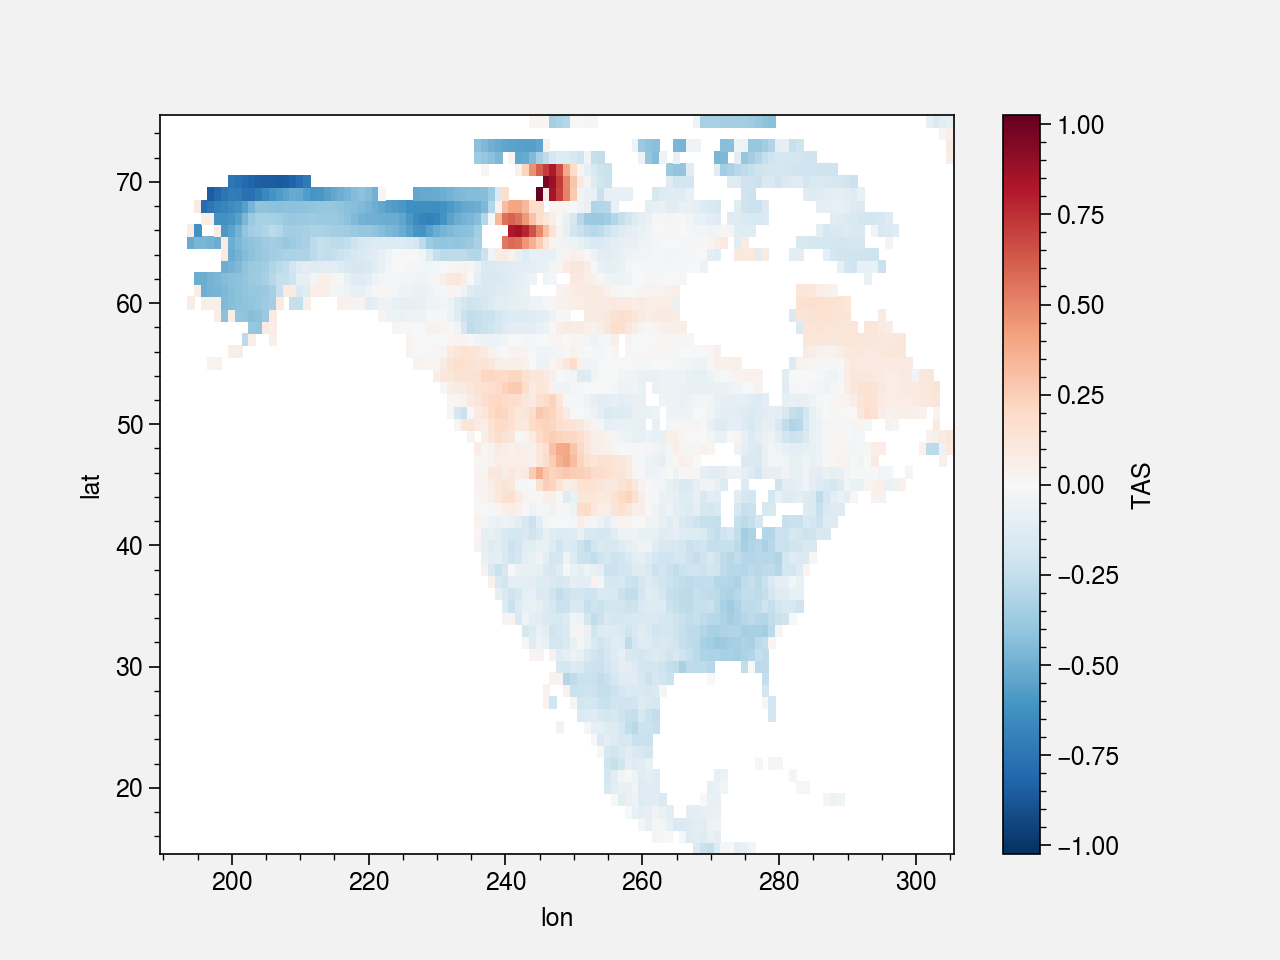

In [88]:
verifw_djf.TAS.mean("time").plot()

In [213]:
hindcastw_djf = climpred.HindcastEnsemble(hindaw_djf).add_observations(verifm_djf)
hindcast1_djf = climpred.HindcastEnsemble(hinda1_djf).add_observations(verifw_djf)
hindcast2_djf = climpred.HindcastEnsemble(hinda2_djf).add_observations(verifm_djf)
hindcast1_5_djf = climpred.HindcastEnsemble(hinda1_5_djf).add_observations(verifw_djf)
hindcast2_5_djf = climpred.HindcastEnsemble(hinda2_5_djf).add_observations(verifm_djf)
hindcast1_jja = climpred.HindcastEnsemble(hinda1_jja).add_observations(verifw_jja)
hindcast2_jja = climpred.HindcastEnsemble(hinda2_jja).add_observations(verifm_jja)
hindcast1_5_jja = climpred.HindcastEnsemble(hinda1_5_jja).add_observations(verifw_jja)
hindcast2_5_jja = climpred.HindcastEnsemble(hinda2_5_jja).add_observations(verifm_jja)

In [219]:
 metric="rps"


In [220]:
if metric=="rps":
    reference="climatology"
    binsw_jja = verifw_jja.quantile(q=[.33, .66], dim="time").rename({'quantile': 'category_edge'})
    binsw_djf = verifw_djf.quantile(q=[.33, .66], dim="time").rename({'quantile': 'category_edge'})
    binsm_jja = verifm_jja.quantile(q=[.33, .66], dim="time").rename({'quantile': 'category_edge'})
    binsm_djf = verifm_djf.quantile(q=[.33, .66], dim="time").rename({'quantile': 'category_edge'})
    rpsw_djf =   hindcastw_djf.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize', category_edges=binsm_djf,reference=reference)
    rps1_djf =   hindcast1_djf.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize', category_edges=binsw_djf,reference=reference)
    rps2_djf =   hindcast2_djf.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize', category_edges=binsm_djf,reference=reference)
    rps1_5_djf = hindcast1_5_djf.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize', category_edges=binsw_djf,reference=reference)
    rps2_5_djf = hindcast2_5_djf.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize', category_edges=binsm_djf,reference=reference)
    rps1_jja = hindcast1_jja.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize', category_edges=binsw_jja,reference=reference)
    rps2_jja = hindcast2_jja.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize', category_edges=binsm_jja,reference=reference)
    rps1_5_jja = hindcast1_5_jja.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize', category_edges=binsw_jja,reference=reference)
    rps2_5_jja = hindcast2_5_jja.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize', category_edges=binsm_jja,reference=reference)
else:
    rpsw_djf = hindcastw_djf.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize')
    rps1_djf = hindcast1_djf.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize')
    rps2_djf = hindcast2_djf.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize')
    rps1_5_djf = hindcast1_5_djf.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize')
    rps2_5_djf = hindcast2_5_djf.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize')
    rps1_jja = hindcast1_jja.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize')
    rps2_jja = hindcast2_jja.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize')
    rps1_5_jja = hindcast1_5_jja.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize')
    rps2_5_jja = hindcast2_5_jja.verify(metric=metric, comparison=comp, dim=dim, alignment='maximize')

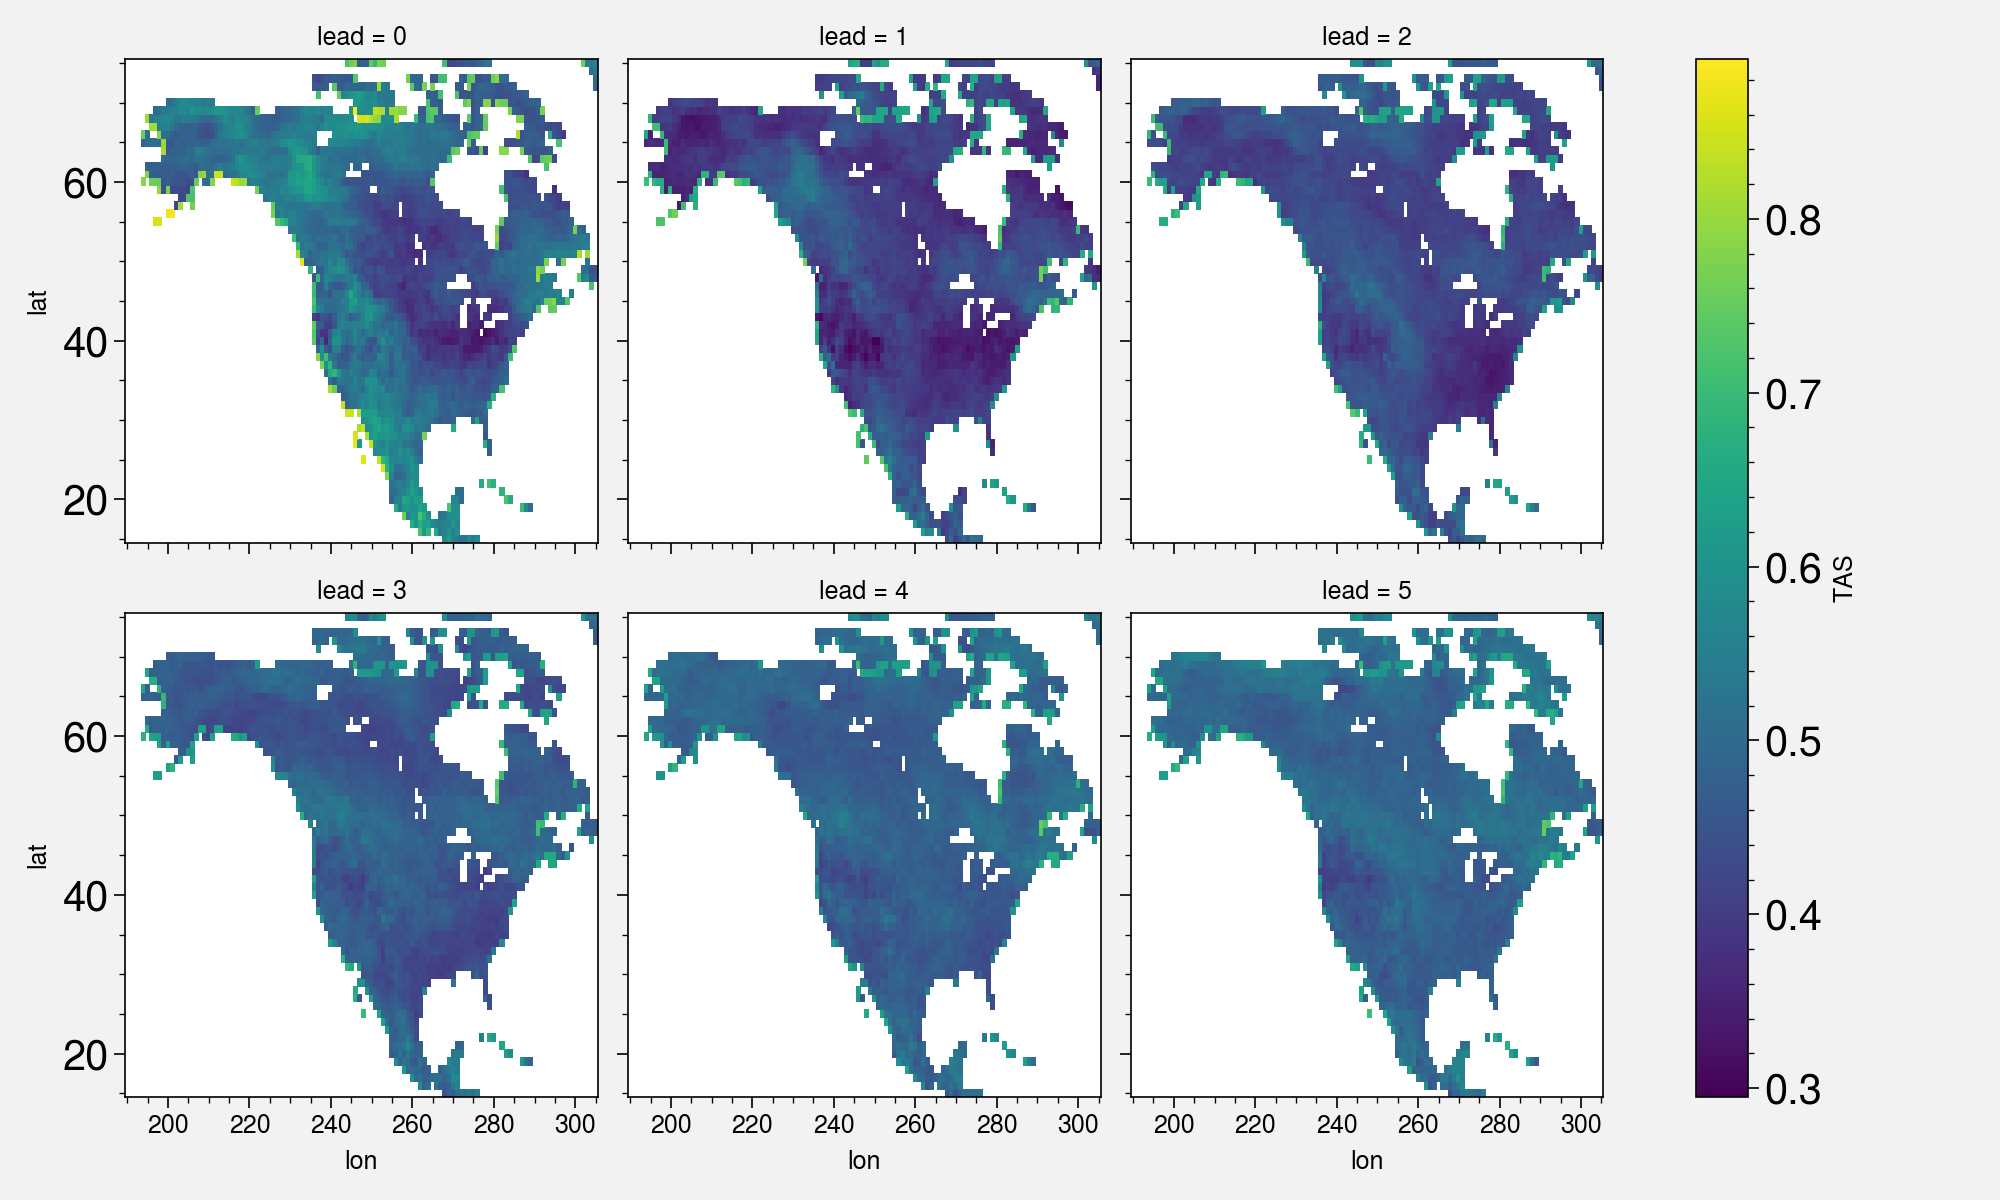

In [221]:
rps2_djf.TAS.sel(skill="initialized").plot(col='lead',col_wrap=3)

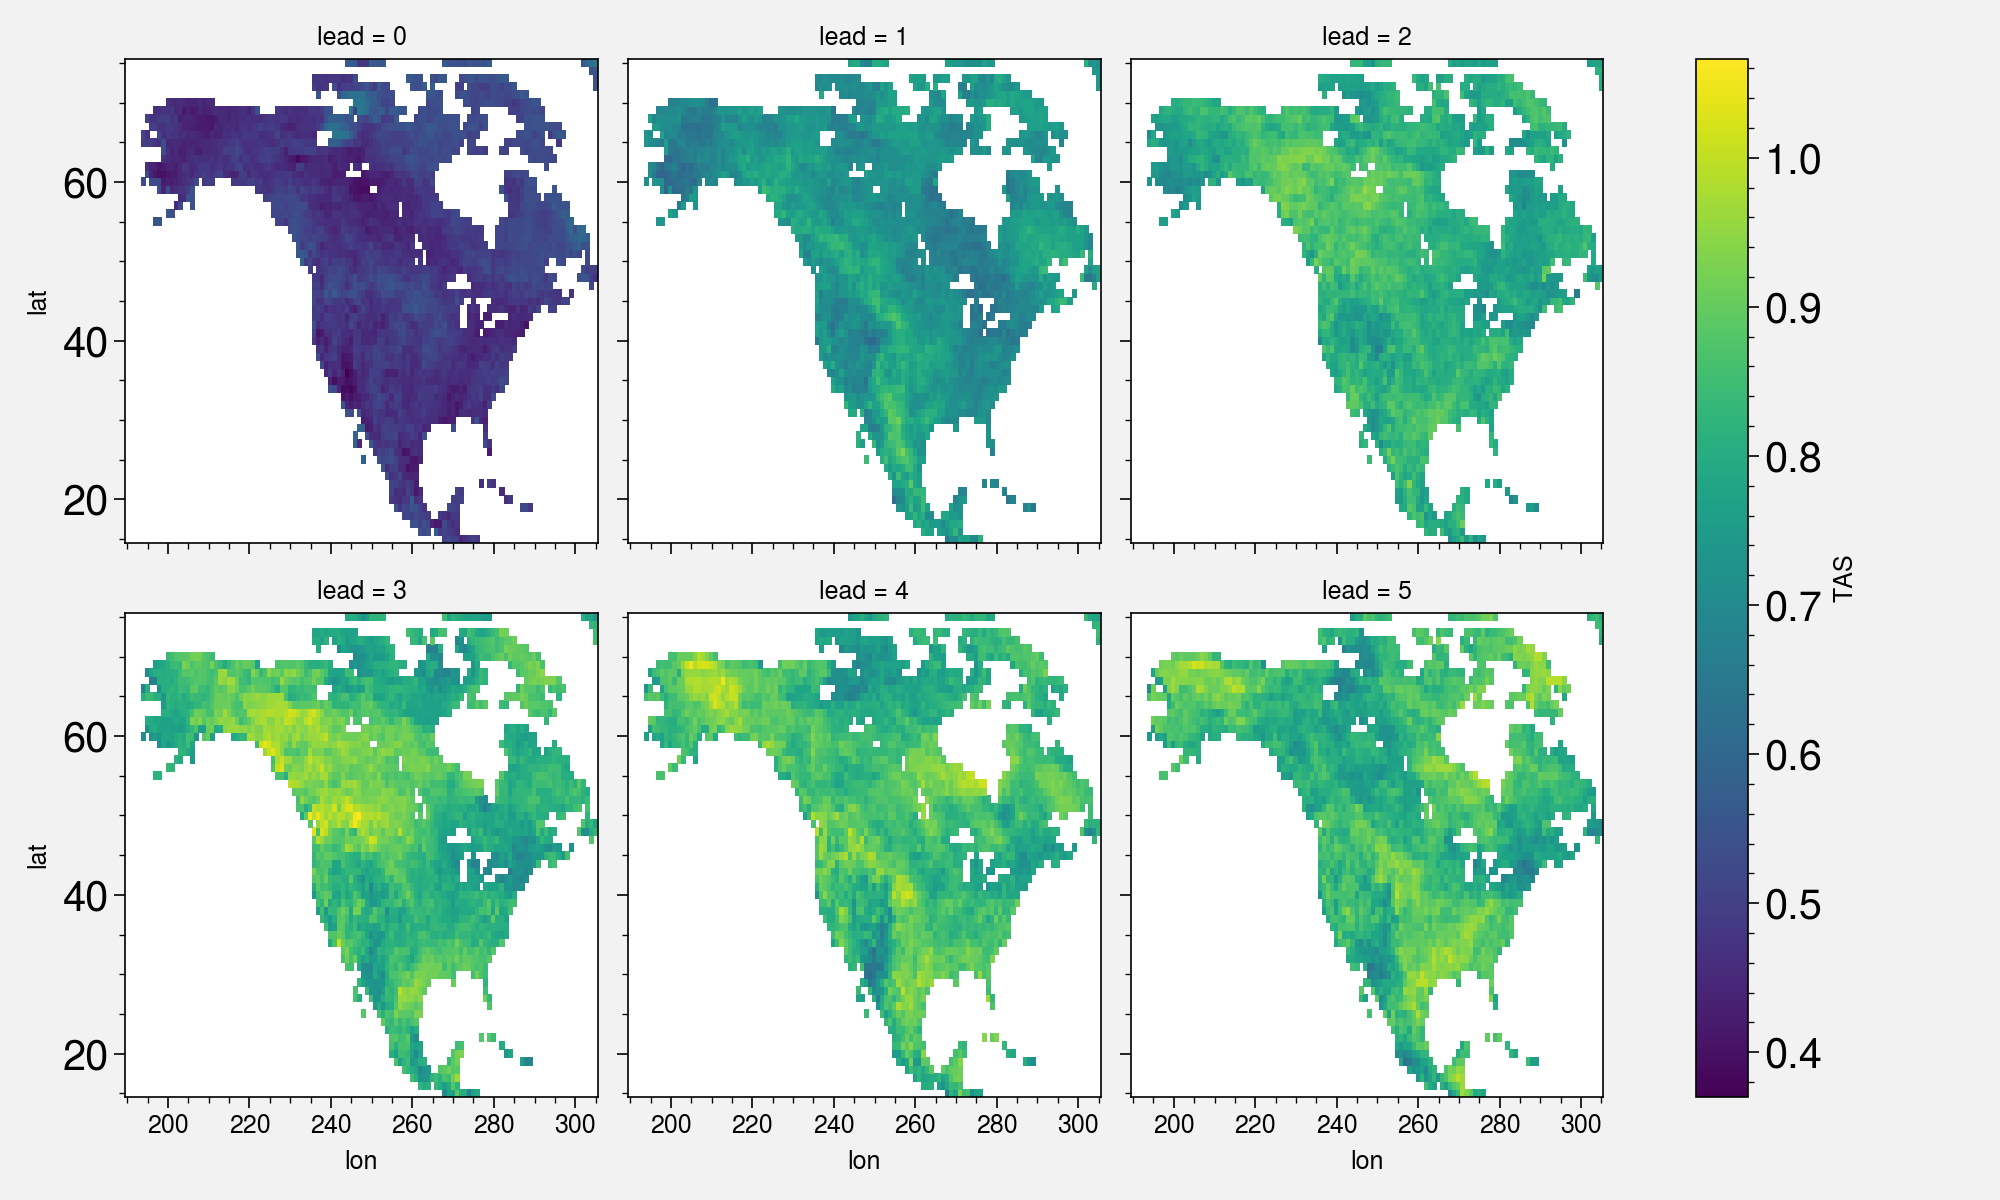

In [223]:
rps2_djf.TAS.sel(skill="climatology").plot(col='lead',col_wrap=3)